In [1]:
import black
import jupyter_black

jupyter_black.load(
    lab=True,
    line_length=110,
    target_version=black.TargetVersion.PY310,
)

In [2]:
import os
import re

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd

from matplotlib.animation import FFMpegWriter, FuncAnimation
from matplotlib.colors import BoundaryNorm, ListedColormap

import lysis

pd.reset_option("display.precision")
pd.set_option("display.float_format", lambda x: f"{x:,.2f}")

In [3]:
experiment_type = np.dtype(
    [
        ("descriptor", np.str_, 40),
        ("file_code", np.str_, 40),
        ("forced_unbind", np.float_),
        ("average_bind_time", np.float_),
    ]
)
code_type = np.dtype([("file_code", np.str_, 40), ("descriptor", np.str_, 40), ("executable", np.str_, 40)])
run_type = np.dtype(
    [
        ("exp_code", np.str_, 15),
        ("experiment", np.str_, 40),
        ("code", np.str_, 40),
        ("seed", int),
        ("running_time", int),
    ]
)

In [4]:
experiments = np.array(
    [
        ("Physiological Kd", "", 8.52e-2, 27.8),
        ("10x bigger", "_Kd0236", 5.4e-3, 2.78),
        ("10x smaller", "_Kd00020036", 0.5143, 277.8),
    ],
    dtype=experiment_type,
)
programs = np.array(
    [
        ("_always", "Always bind", "macro_Q2_always_rebind"),
        ("_along", "Diffuse along clot", "macro_Q2_diffuse_along"),
        ("_into", "Diffuse into clot", "macro_Q2_diffuse_into"),
        # (
        #     "_into_and_along",
        #     "Diffuse into and along clot - BUGGED",
        #     "macro_Q2_diffuse_into_and_along",
        # ),
        (
            "_into_and_along_fixed",
            "Diffuse into and along clot",
            "macro_Q2_diffuse_into_and_along_fixed",
        ),
    ],
    dtype=code_type,
)
runs = np.empty(15, dtype=run_type)

In [5]:
in_file_code = "_PLG2_tPA01{data_code}_Q2.dat"
out_file_code = "_PLG2_tPA01{data_code}{program_code}_Q2.dat"

slope_tolerance = 1e-3
rng = np.random.default_rng(65463453)

In [6]:
group_code = "2023-02-02-22"
runs = np.array(
    [
        (group_code + "00", "Physiological Kd", "Diffuse along clot", 17109424, 1200),
        (group_code + "01", "Physiological Kd", "Always bind", 9965734, 1800),
        # (group_code + "02", "Physiological Kd", "Diffuse into and along clot - BUGGED", -2137354075, 1200),
        (group_code + "03", "Physiological Kd", "Diffuse into and along clot", -2137354075, 1800),
        (group_code + "04", "Physiological Kd", "Diffuse into clot", -2135977853, 1200),
        (group_code + "05", "10x smaller", "Diffuse along clot", -848304637, 1200),
        (group_code + "06", "10x smaller", "Always bind", 1299539472, 1800),
        # (group_code + "07", "10x smaller", "Diffuse into and along clot - BUGGED", -854989241, 1200),
        (group_code + "08", "10x smaller", "Diffuse into and along clot", -854989241, 1800),
        (group_code + "09", "10x smaller", "Diffuse into clot", -850336215, 1200),
        (group_code + "10", "10x bigger", "Diffuse along clot", -1216563743, 1200),
        (group_code + "11", "10x bigger", "Always bind", 669985532, 900),
        # (group_code + "12", "10x bigger", "Diffuse into and along clot - BUGGED", -1212172957, 1200),
        (group_code + "13", "10x bigger", "Diffuse into and along clot", -1212172957, 1800),
        (group_code + "14", "10x bigger", "Diffuse into clot", -1213352577, 1200),
    ],
    dtype=run_type,
)

In [7]:
index = pd.MultiIndex.from_product(
    [experiments["descriptor"], programs["descriptor"]], names=["data", "program"]
)
# index = [run['experiment'] + " - " + run['code'] for run in runs]
statistics = ["Mean front velocity", "Mean of Standard Deviation of front velocity"]
results = pd.DataFrame(index=index, columns=statistics)
# front_velocity_table = pd.DataFrame(index=programs["descriptor"], columns=experiments["descriptor"])

In [8]:
colormap_f = plt.cm.cividis(np.arange(plt.cm.cividis.N))
colormap_f[:, 3] = 0.3
colormap_f = ListedColormap(colormap_f)
colormap_f.set_extremes(bad="#0c21c4", under="w", over="#0c21c4")
colormap_m = ListedColormap(["green", "#00fffb"])
bounds = [0, 0.5, 1]
norm_m = BoundaryNorm(bounds, colormap_m.N)

In [9]:
def load_fortran_files(exp, file_code):
    n_save = np.fromfile(os.path.join(e.os_path, "Nsave" + file_code), dtype=np.int32)
    n_save += 1
    raw_deg = np.fromfile(os.path.join(e.os_path, "deg" + file_code))
    raw_tsave = np.fromfile(os.path.join(e.os_path, "tsave" + file_code))
    raw_mol_location = np.fromfile(os.path.join(e.os_path, "m_loc" + file_code), dtype=np.int32)
    raw_mol_status = np.fromfile(os.path.join(e.os_path, "m_bound" + file_code), dtype=np.int32)
    raw_mol_status = raw_mol_status.astype(np.bool_)
    raw_mfpt = np.fromfile(os.path.join(e.os_path, "mfpt" + file_code))

    mfpt = raw_mfpt.reshape(raw_mfpt.size // e.macro_params.total_molecules, e.macro_params.total_molecules)
    if mfpt.shape[0] > e.macro_params.total_trials:
        mfpt = mfpt[: e.macro_params.total_trials]
    # mfpt = mfpt[mfpt[:, -1] != 0]

    raw_mapped_deg = -raw_deg
    raw_mapped_deg[raw_deg == 0] = np.max(raw_tsave) + e.macro_params.save_interval  # float('inf') #
    raw_mapped_deg[raw_deg == -1] = 0

    mapped_deg = []
    tsave = []
    mol_location = []
    mol_status = []
    start = 0
    end = 0
    for r in range(e.macro_params.total_trials):
        start = end
        end += n_save[r]
        mapped_deg.append(
            raw_mapped_deg[start * e.macro_params.total_edges : end * e.macro_params.total_edges].reshape(
                n_save[r], e.macro_params.total_edges
            )
        )
        mol_location.append(
            raw_mol_location[
                start * e.macro_params.total_molecules : end * e.macro_params.total_molecules
            ].reshape(n_save[r], e.macro_params.total_molecules)
            - 1
        )
        mol_status.append(
            raw_mol_status[
                start * e.macro_params.total_molecules : end * e.macro_params.total_molecules
            ].reshape(n_save[r], e.macro_params.total_molecules)
        )
        tsave.append(raw_tsave[start:end])
    return n_save, mapped_deg, tsave, mfpt, mol_location, mol_status


In [11]:
import h5py
import dataclasses

In [12]:
f = h5py.File(os.path.join(e.os_path, "2023-02-02-2214.hdf5"), "w")

In [13]:
run = runs[-1]
prog = programs[programs["descriptor"] == run["code"]]
exper = experiments[experiments["descriptor"] == run["experiment"]]
e = lysis.util.Experiment(os.path.join("..", "..", "data"), experiment_code=run["exp_code"])
# e = lysis.util.Experiment(
#     os.path.join("/", "home", "bpaynter", "Archive", "lysis_data"), experiment_code=run["exp_code"]
# )
e.read_file()
y_distance = np.arange(e.macro_params.rows - 1) * e.macro_params.grid_node_distance
file_code = out_file_code.format(data_code=exper["file_code"][0], program_code=prog["file_code"][0])
print(run["exp_code"], file_code)
n_save, deg, tsave, mfpt, mol_location, mol_status = load_fortran_files(e, file_code)

2023-02-02-2214 _PLG2_tPA01_Kd0236_into_Q2.dat


In [23]:
deg[0].shape

(62, 33545)

In [25]:
mfpt[0]

array([387.5226507 , 325.43359242, 352.48512176, ..., 389.51196032,
       531.60653209, 385.80999549])

In [14]:
for k, v in dataclasses.asdict(e.macro_params).items():
    print(k, v)
    f.attrs.create(k, v)

binding_rate 0.1
pore_size 0.00010135
diffusion_coeff 5e-07
binding_sites 427
forced_unbind 0.0054
average_bind_time 2.78
grid_node_distance 1.0862
cols 93
rows 121
full_row 278
xz_row 185
total_edges 33545
total_fibers 25761
empty_rows 28
last_empty_edge 7783
total_molecules 43074
moving_probability 0.2
microscale_runs 50000
total_trials 10
total_time 0
time_step 0.0003423940833333333
total_time_steps 0
seed -1213352577
state (129281, 362436069, 123456789, -1213352577)
input_data ['unbinding_time', 'lysis_time', 'total_lyses']
output_data ['degradation_state', 'molecule_location', 'molecule_state', 'save_time']
save_interval 10
number_of_saves 1
macro_version macro_PLG2_tPA01_Kd0236_into_Q2
log_lvl 30
duplicate_fortran False
processing_library numpy


In [15]:
group = f.create_group("0")

In [16]:
group.create_dataset("tsave", data=tsave[0])

<HDF5 dataset "tsave": shape (62,), type "<f8">

In [17]:
group["tsave"].dims[0].label = "Experiment Time (sec)"

In [40]:
group["tsave"].make_scale("Time Stamp")

In [18]:
group.create_dataset("deg", data=deg[0])

<HDF5 dataset "deg": shape (62, 33545), type "<f8">

In [42]:
group["deg"].dims[0].attach_scale(group["tsave"])

In [20]:
group["deg"].dims[0].label = "Experiment Time (sec)"
group["deg"].dims[1].label = "Fiber Index (fortran)"

In [25]:
f.close()

In [22]:
group

<Closed HDF5 group>

In [46]:
from jupyterlab_h5web import H5Web

H5Web(os.path.join(e.os_path, "2023-02-02-2214.hdf5"))

<jupyterlab_h5web.widget.H5Web object>

In [24]:
from h5glance import H5Glance

f = h5py.File(os.path.join(e.os_path, "2023-02-02-2214.hdf5"), "r")
H5Glance(f)

2023-02-02-2214.hdf5/ (32 attributes)
└0	(2 children)

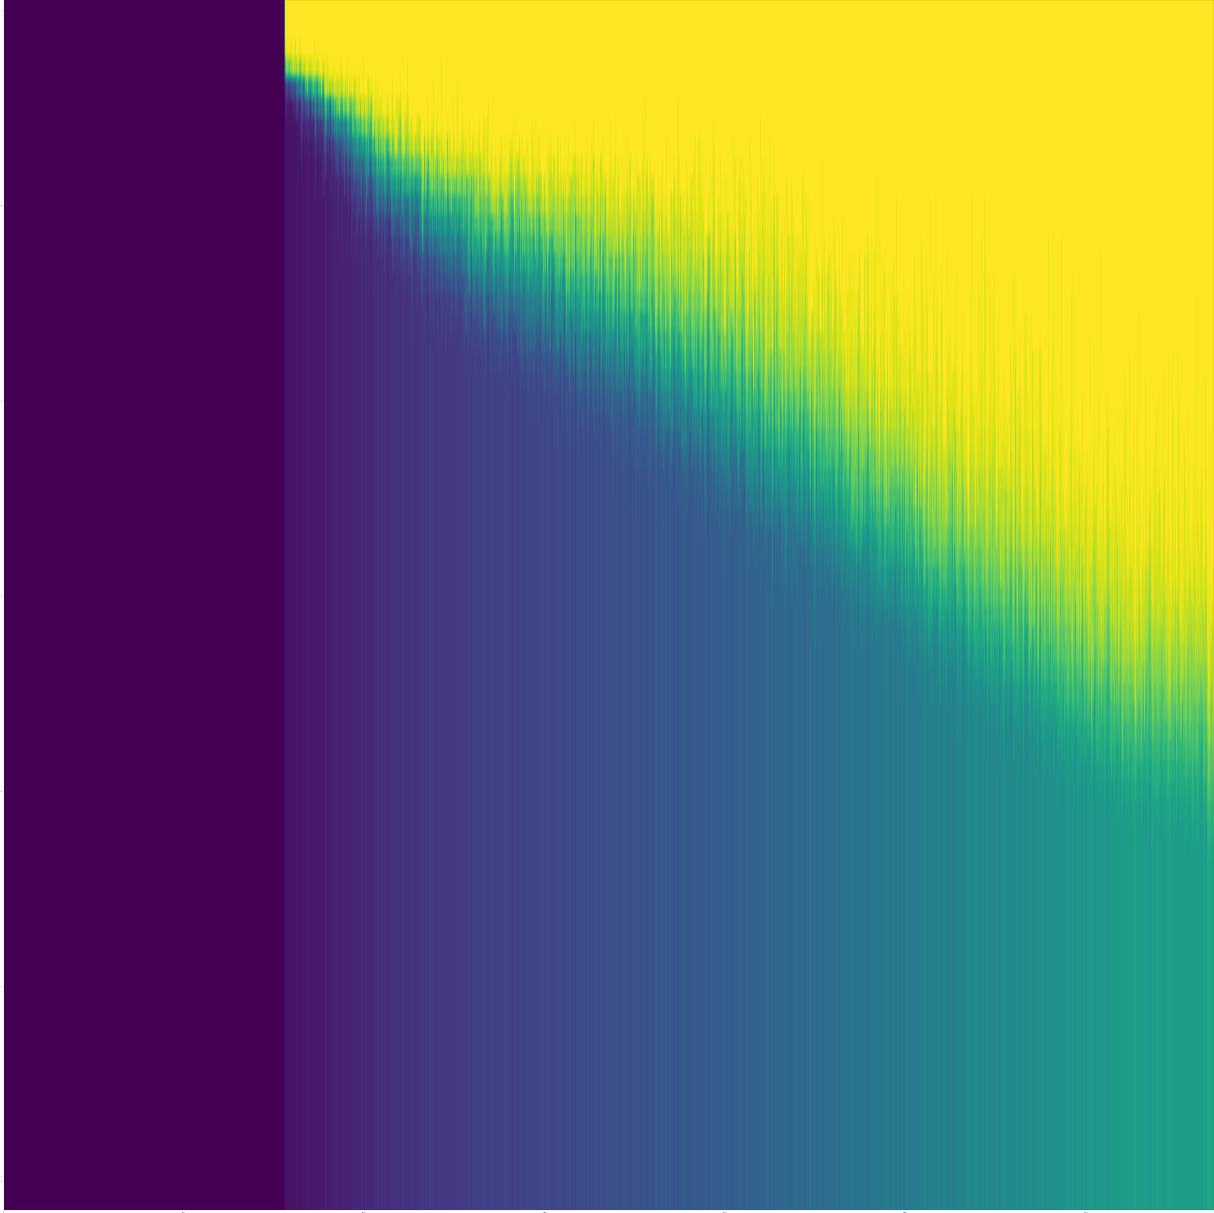

In [33]:
fig = plt.figure(figsize=(121, 121), dpi=10)
ax = fig.add_axes([0, 0, 1, 1])
ax.imshow(deg[0], aspect="auto")